In [12]:
import pandas as pd
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, GlobalAvgPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.callbacks import ReduceLROnPlateau
from keras.applications import ResNet50
import keras

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
y_train = train_df["label"].values
x_train = train_df[train_df.keys().drop(["label"])].values.reshape(-1,28,28,1)
x_train = x_train/255

In [4]:
test = test_df.values
test = test/255
test = test.reshape(-1, 28,28,1)

In [5]:
y_train = to_categorical(y_train, num_classes=10)

In [6]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

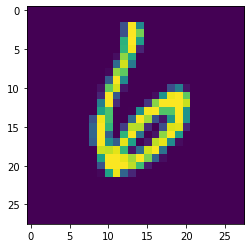

In [8]:
plt.imshow(x_train[0][:,:,0])

In [9]:
# model = Sequential()
# model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=(28,28,1), activation="relu", padding="Same"))
# model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding="Same"))
# model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="Same"))
# model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="Same"))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="Same"))
# model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="Same"))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(256, activation="relu"))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation="softmax"))
# model.summary()

# model = Sequential()

# model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
# model.add(BatchNormalization())

# model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
# model.add(BatchNormalization())

# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
# model.add(BatchNormalization())

# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(256, activation = "relu"))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(10, activation = "softmax"))
# model.summary()

#designing the model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(28, 28, 1), name='conv1'))
model.add(Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(28, 28, 1), name='conv2'))
model.add(MaxPool2D(pool_size=(2, 2),name='pool1'))
model.add(Conv2D(filters=32, kernel_size=5, strides=1,padding='same', activation='relu',name='conv3'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1,padding='same', activation='relu',name='conv4'))
model.add(MaxPool2D(pool_size=(2, 2),name='pool2'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1,padding='same', activation='relu',name='conv5'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1,padding='valid', activation='relu',name='conv6'))
model.add(Flatten(name='flat'))
model.add(Dense(512,activation='relu',name='dense1'))
model.add(Dropout(0.2,name='dropout'))
model.add(Dense(10,activation='softmax',name='res'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 16)        416       
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 16)        6416      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 32)        12832     
_________________________________________________________________
conv4 (Conv2D)               (None, 14, 14, 32)        9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 7, 32)          0         
_________________________________________________________________
conv5 (Conv2D)               (None, 7, 7, 64)         

In [13]:
model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), loss="categorical_crossentropy", metrics=["accuracy"])
checkpoint = keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True, monitor='val_acc', mode='max')

In [14]:
igen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.1,
    height_shift_range=0.1
)
igen.fit(x_train)

In [15]:
lr = ReduceLROnPlateau(min_lr=0.00001, patience=3, verbose=1, factor=0.5, monitor="val_accuracy")

In [17]:
model.fit(igen.flow(x_train, y_train, batch_size=128), epochs=50, validation_data=(x_val, y_val),
         verbose = 2, steps_per_epoch=x_train.shape[0] // 128, callbacks=[lr, checkpoint])

Epoch 1/50
 - 6s - loss: 0.1269 - accuracy: 0.9613 - val_loss: 0.0508 - val_accuracy: 0.9850
Epoch 2/50


c:\users\ashuk\.conda\envs\tensorflow_env\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 5s - loss: 0.0790 - accuracy: 0.9754 - val_loss: 0.0657 - val_accuracy: 0.9813
Epoch 3/50
 - 5s - loss: 0.0597 - accuracy: 0.9817 - val_loss: 0.0459 - val_accuracy: 0.9854
Epoch 4/50
 - 5s - loss: 0.0491 - accuracy: 0.9851 - val_loss: 0.0352 - val_accuracy: 0.9888
Epoch 5/50
 - 5s - loss: 0.0474 - accuracy: 0.9855 - val_loss: 0.0317 - val_accuracy: 0.9907
Epoch 6/50
 - 5s - loss: 0.0404 - accuracy: 0.9872 - val_loss: 0.0335 - val_accuracy: 0.9900
Epoch 7/50
 - 5s - loss: 0.0362 - accuracy: 0.9897 - val_loss: 0.0256 - val_accuracy: 0.9919
Epoch 8/50
 - 5s - loss: 0.0330 - accuracy: 0.9896 - val_loss: 0.0261 - val_accuracy: 0.9923
Epoch 9/50
 - 5s - loss: 0.0308 - accuracy: 0.9904 - val_loss: 0.0365 - val_accuracy: 0.9895
Epoch 10/50
 - 6s - loss: 0.0311 - accuracy: 0.9907 - val_loss: 0.0244 - val_accuracy: 0.9924
Epoch 11/50
 - 5s - loss: 0.0274 - accuracy: 0.9914 - val_loss: 0.0381 - val_accuracy: 0.9921
Epoch 12/50
 - 6s - loss: 0.0262 - accuracy: 0.9920 - val_loss: 0.0383 - val_ac

In [18]:
result = model.predict(test)

In [19]:
result = np.argmax(result, axis=1)

In [20]:
result

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [21]:
sub = pd.read_csv("sample_submission (1).csv")

In [22]:
sub["Label"] = result

In [23]:
sub.to_csv("try8.csv", index=False)